In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error as mse
import scipy.stats as ss
from collections import Counter
import math 
from scipy import stats


%matplotlib inline

In [2]:
anes = pd.read_csv('data/anes_pilot_2020ets_csv.csv')

In [3]:
data = anes.copy(deep = True)

In [4]:
data.drop(inplace=True, columns=[ 'V1', 'StartDate', 'EndDate', '_v1', 'RecordedDate', 'ResponseId','qmetadata_Browser', 'qmetadata_Version', '_v2', 'qmetadata_Resolution', 'check','relig1_11_TEXT', 'mauga', 'pk_cjus', 'pk_germ', 'ethnic1', 'ethnic2', 'ethnic3'])

In [5]:
data.dropna(inplace=True)

In [6]:
data.head()

,follow,reg1,votemail1a,votemail1b,votecount,votemail2,voterid1,voterid2,turnout16a,turnout16a1,...,rr_scale,white,black,namer,asian,hpi,mixed,race7,vidx,vidknow
0,1,1,4,77,4,4,1,2,1,6,...,9,1,0,0,0,0,0,1,2.0,1
1,2,1,5,77,3,4,1,1,1,6,...,16,1,0,0,0,0,0,1,3.0,0
2,2,4,4,77,3,3,1,1,2,6,...,6,0,0,0,0,0,0,5,3.0,0
3,2,1,6,77,3,4,1,1,1,6,...,13,1,0,0,0,0,0,1,3.0,1
4,4,1,1,77,3,2,1,2,1,6,...,4,0,1,0,0,0,0,2,2.0,0


In [7]:
data.drop(data[data['mis_covid1'] == 9].index, inplace=True)

In [8]:
data.drop(data[data['mis_covid2'] == 9].index, inplace=True)

In [9]:
data['mis_covid2'].value_counts(normalize=True)

2    0.795573
1    0.204427
Name: mis_covid2, dtype: float64

In [10]:
data['facebook1'].value_counts()

1     1001
66     621
2      551
3      401
4      229
5      107
7       85
6       77
Name: facebook1, dtype: int64

In [11]:
data.rename(columns={"mis_covid1": 'covid_lab'}, inplace = True)

In [12]:
data.rename(columns={"mis_covid2": 'covid_vax'}, inplace = True)

In [13]:
data.covid_lab.replace((2,1), (0,1), inplace=True)

In [14]:
data.covid_vax.replace((2,1), (0,1), inplace=True)

In [15]:
data['covid_mis_score'] = data['covid_lab'] + data['covid_vax']

In [16]:
data['covid_mis_score'].value_counts()

0    1577
1    1002
2     493
Name: covid_mis_score, dtype: int64

In [17]:
data.drop(inplace=True, columns=['covid_lab', 'covid_vax'])

# feature selection

In [18]:
features = data.columns
traindf = pd.DataFrame(data, columns=features)
y = traindf['covid_mis_score']>=1
X = traindf.copy()
del X['covid_mis_score']

In [19]:
X.head()

,follow,reg1,votemail1a,votemail1b,votecount,votemail2,voterid1,voterid2,turnout16a,turnout16a1,...,rr_scale,white,black,namer,asian,hpi,mixed,race7,vidx,vidknow
0,1,1,4,77,4,4,1,2,1,6,...,9,1,0,0,0,0,0,1,2.0,1
1,2,1,5,77,3,4,1,1,1,6,...,16,1,0,0,0,0,0,1,3.0,0
2,2,4,4,77,3,3,1,1,2,6,...,6,0,0,0,0,0,0,5,3.0,0
3,2,1,6,77,3,4,1,1,1,6,...,13,1,0,0,0,0,0,1,3.0,1
4,4,1,1,77,3,2,1,2,1,6,...,4,0,1,0,0,0,0,2,2.0,0


In [40]:
feature_name = list(X.columns)
# no of maximum features we need to select
num_feats=100

## pearson

In [41]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

100 selected features


In [42]:
cor_feature

['pid1r',
 'voterid2',
 'knowgay2_5',
 'knowtran2_2',
 'expconvert',
 'vote20jb',
 'socmed_6',
 'pidstr1',
 'impact2',
 'vidx',
 'expfight',
 'childrear4',
 'knowtran1',
 'dejavu',
 'hlthcare2',
 'expbuyus',
 'diversity7',
 'socmed_3',
 'vote20bs',
 'pidstr3',
 'protest',
 'expshark',
 'pk_sen_correct',
 'childrear2',
 'abort_imp',
 'exppubasst',
 'meeting',
 'pidstr2',
 'dtauth',
 'femid2_anti',
 'ftpence1',
 'ftobama1',
 'gayadopt',
 'exphelp',
 'expknowpris',
 'pathway',
 'socmed_7',
 'rr_scale',
 'covid_elect',
 'viol3_reps',
 'att1',
 'att2',
 'compro2',
 'impeach1',
 'talk3',
 'callout_social',
 'knowtran2_1',
 'excessive',
 'rural2',
 'childrear3',
 'rural4',
 'exparrest',
 'votemail2',
 'impact3',
 'science',
 'fundmt1',
 'lcself',
 'dtknow',
 'impact5',
 'serious',
 'pk_cjus_correct',
 'pk_cjus_correctb',
 'exphomesch',
 'birthyr',
 'age',
 'talk2',
 'frnpres7',
 'impact1',
 'pid7',
 'fttrump1',
 'econpres7',
 'viol1',
 'happy',
 'impact4',
 'dtcares',
 'whitejob',
 'hopeful',

# chi squared

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


In [44]:
chi_feature

['reg1',
 'votemail2',
 'voterid2',
 'hopeful',
 'happy',
 'proud',
 'meeting',
 'protest',
 'button',
 'argument',
 'particip_none',
 'talk2',
 'talk3',
 'fttrump1',
 'ftharris1',
 'ftklobuchar1',
 'ftpence1',
 'ftyang1',
 'ftrubio1',
 'ftocasioc1',
 'fthaley1',
 'cvote2020',
 'apppres7',
 'immpres7',
 'econpres7',
 'dtdignif',
 'dthonest',
 'econnow',
 'taxecon',
 'lcself',
 'lcr',
 'wall7',
 'pathway',
 'return',
 'abort1',
 'abort_imp',
 'abort2',
 'gayadopt',
 'diversity7',
 'experts',
 'childrear4',
 'rural2',
 'rural4',
 'conf_covid2',
 'impeach1',
 'impeach2',
 'pidstr2',
 'rr1',
 'rr4',
 'att1',
 'att2',
 'fundmt1',
 'fundmt2',
 'socmed_2',
 'socmed_3',
 'socmed_6',
 'socmed_7',
 'socmed_9',
 'facebook1',
 'twitter1',
 'impact1',
 'impact2',
 'impact3',
 'impact4',
 'impact5',
 'impact6',
 'impact8',
 'impact9',
 'whitejob',
 'knowtran1',
 'knowtran2_1',
 'knowtran2_2',
 'knowtran2_3',
 'knowgay2_1',
 'knowgay2_2',
 'knowgay2_4',
 'knowgay2_5',
 'knowgay2_6',
 'viol3_reps',
 '

# Recursive elimination - logistic

In [45]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 450 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 440 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 430 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 420 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 410 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 400 features.
Fitting estimator with 390 features.

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html


Fitting estimator with 380 features.
Fitting estimator with 370 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 360 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 350 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 340 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 330 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 320 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 310 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 300 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 290 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 280 features.
Fitting estimator with 270 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 260 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 250 features.
Fitting estimator with 240 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 230 features.
Fitting estimator with 220 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 210 features.
Fitting estimator with 200 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 190 features.
Fitting estimator with 180 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 170 features.
Fitting estimator with 160 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 150 features.
Fitting estimator with 140 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting estimator with 130 features.
Fitting estimator with 120 features.
Fitting estimator with 110 features.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10,
    verbose=5)

In [46]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


In [47]:
rfe_feature

['votemail1a',
 'votemail1b',
 'votecount',
 'votemail2',
 'turnout16b',
 'worried',
 'irritated',
 'talk2',
 'fttrump1',
 'ftobama1',
 'ftpence1',
 'ftrubio1',
 'ftblack',
 'ftwhite',
 'fttransppl',
 'ftsocialists',
 'ftcapitalists',
 'ftdemocraticparty',
 'primaryvote',
 'vote20jb',
 'frnpres7',
 'immpres7',
 'econpres7',
 'jbleader1',
 'jbdiv',
 'bscares',
 'bsauth',
 'econnow',
 'confecon',
 'taxecon',
 'lcself',
 'freemkt1a',
 'tol_pres',
 'racist1',
 'immignum',
 'return',
 'open',
 'covid1',
 'covid2',
 'covid_elect',
 'abort1',
 'abort_imp',
 'freecol2',
 'loans2',
 'experts',
 'exphelp',
 'excessive',
 'selfcensor',
 'childrear2',
 'childrear3',
 'conf_covid2',
 'pidstr2',
 'rr1',
 'relig1',
 'att3',
 'fundmt1',
 'impact8',
 'groupid1a_lat',
 'groupid2a_nat',
 'groupid2a_asi',
 'groupid3a_bla',
 'groupid1b_lat',
 'groupid3b_lat',
 'groupid3b_asi',
 'whitejob',
 'knowtran2_2',
 'stress2',
 'depress3',
 'speech1',
 'moralsup1',
 'moralcert3',
 'intelsup1',
 'moralcert6',
 'duepr

# lasso

In [48]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SelectFromModel(estimator=LogisticRegression(), max_features=100)

In [49]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

100 selected features


In [50]:
embeded_lr_feature

['votecount',
 'votemail2',
 'voterid1',
 'voterid2',
 'turnout16b',
 'hopeful',
 'worried',
 'irritated',
 'talk2',
 'talk3',
 'ftobama1',
 'ftwarren1',
 'ftbuttigieg1',
 'ftpence1',
 'ftrubio1',
 'fthaley1',
 'ftblack',
 'ftwhite',
 'fttransppl',
 'ftsocialists',
 'ftdemocraticparty',
 'primaryvote',
 'vote20jb',
 'immpres7',
 'econpres7',
 'econnow',
 'confecon',
 'taxecon',
 'lcself',
 'lcd',
 'freemkt1a',
 'racist1',
 'immignum',
 'return',
 'open',
 'covid1',
 'covid2',
 'covid_elect',
 'abort1',
 'abort_imp',
 'harass',
 'experts',
 'exphelp',
 'excessive',
 'compro2',
 'childrear2',
 'childrear3',
 'rural3',
 'conf_covid2',
 'pidstr2',
 'rr1',
 'relig1',
 'att3',
 'fundmt1',
 'impact7',
 'impact8',
 'groupid2a_nat',
 'groupid2a_asi',
 'groupid1b_lat',
 'groupid3b_whi',
 'groupid3b_asi',
 'whitejob',
 'knowtran2_1',
 'knowtran2_2',
 'stress2',
 'depress1',
 'depress2',
 'depress3',
 'speech1',
 'duepro3',
 'intelsup1',
 'moralcert6',
 'duepro1',
 'duepro2',
 'intelsup2',
 'moral

# Embeddes RF

In [51]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), max_features=100)

In [52]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

100 selected features


In [53]:
embeded_rf_feature

['votecount',
 'votemail2',
 'outraged',
 'angry',
 'proud',
 'irritated',
 'talk1',
 'talk2',
 'talk3',
 'fttrump1',
 'ftobama1',
 'ftbiden1',
 'ftwarren1',
 'ftsanders1',
 'ftbuttigieg1',
 'ftharris1',
 'ftklobuchar1',
 'ftpence1',
 'ftyang1',
 'ftpelosi1',
 'ftrubio1',
 'ftocasioc1',
 'fthaley1',
 'ftthomas1',
 'ftfauci1',
 'ftblack',
 'ftwhite',
 'fthisp',
 'ftasian',
 'ftillegal',
 'ftfeminists',
 'ftmetoo',
 'fttransppl',
 'ftsocialists',
 'ftcapitalists',
 'ftbigbusiness',
 'ftlaborunions',
 'ftrepublicanparty',
 'ftdemocraticparty',
 'apppres7',
 'frnpres7',
 'immpres7',
 'dtcares',
 'dtdignif',
 'dthonest',
 'dtdiv',
 'dtknow',
 'econnow',
 'taxecon',
 'lcself',
 'lcd',
 'lcr',
 'immignum',
 'wall7',
 'return',
 'affact',
 'hlthcare1',
 'covid_elect',
 'abort1',
 'abort_imp',
 'abort2',
 'gayadopt',
 'diversity7',
 'experts',
 'excessive',
 'rural2',
 'rural3',
 'rural4',
 'conf_covid1',
 'conf_covid2',
 'impeach2',
 'pidstr3',
 'rr4',
 'relig1',
 'fundmt1',
 'fundmt2',
 'face

# why not try them all

In [54]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,whitejob,True,True,True,True,True,5
2,votemail2,True,True,True,True,True,5
3,viol1,True,True,True,True,True,5
4,taxecon,True,True,True,True,True,5
5,talk2,True,True,True,True,True,5
6,return,True,True,True,True,True,5
7,lcself,True,True,True,True,True,5
8,impact8,True,True,True,True,True,5
9,immpres7,True,True,True,True,True,5
10,fundmt1,True,True,True,True,True,5


In [55]:
'''

ok so my intial project idea was something along the lines of what predicts covid misinformation - the end goal of the project is that we have more research on how/why misinformation gets spread 

from my featuree importance i see here the things that predict misinformation 

so what i can do with this?

go into the demographic data and see which demographics correlate the most?

then find the correlations between my most important features and my most important demographics? 





so now i can just make sure that all the top 16 features are on the same 1-7 or 1-5 scale, so that when i look at the putput that moves the coef for covis_mis, its going in the same direction 


'''

'\n\nok so my intial project idea was something along the lines of what predicts covid misinformation - the end goal of the project is that we have more research on how/why misinformation gets spread \n\nfrom my featuree importance i see here the things that predict misinformation \n\nso what i can do with this?\n\ngo into the demographic data and see which demographics correlate the most?\n\nthen find the correlations between my most important features and my most important demographics? \n\n\n\n\n\nso now i can just make sure that all the top 16 features are on the same 1-7 or 1-5 scale, so that when i look at the putput that moves the coef for covis_mis, its going in the same direction \n\n\n'

In [ ]:
# lets make sure all these variables are on the same scale 

In [67]:
#creating a dataframe with these 16 features 



features16 = data[['whitejob', 'votemail2', 'viol1', 'taxecon', 'talk2', 'return', 'lcself', 'impact8', 'immpres7', 'fundmt1', 'ftpence1', 'experts', 'econnow', 'conf_covid2', 'abort_imp', 'abort1', 'covid_mis_score']]

In [68]:
features16.head()

,whitejob,votemail2,viol1,taxecon,talk2,return,lcself,impact8,immpres7,fundmt1,ftpence1,experts,econnow,conf_covid2,abort_imp,abort1,covid_mis_score
0,3,4,3,4,3,4,4,3,5,2,70,3,2,5,2,4,0
1,3,4,2,2,5,1,6,3,1,1,70,4,2,4,3,4,0
2,2,3,3,3,4,5,4,4,7,6,20,4,5,4,3,2,0
3,4,4,4,3,4,1,4,5,1,2,80,4,5,2,4,4,0
4,6,2,4,5,2,3,4,5,7,2,0,4,5,4,5,4,0


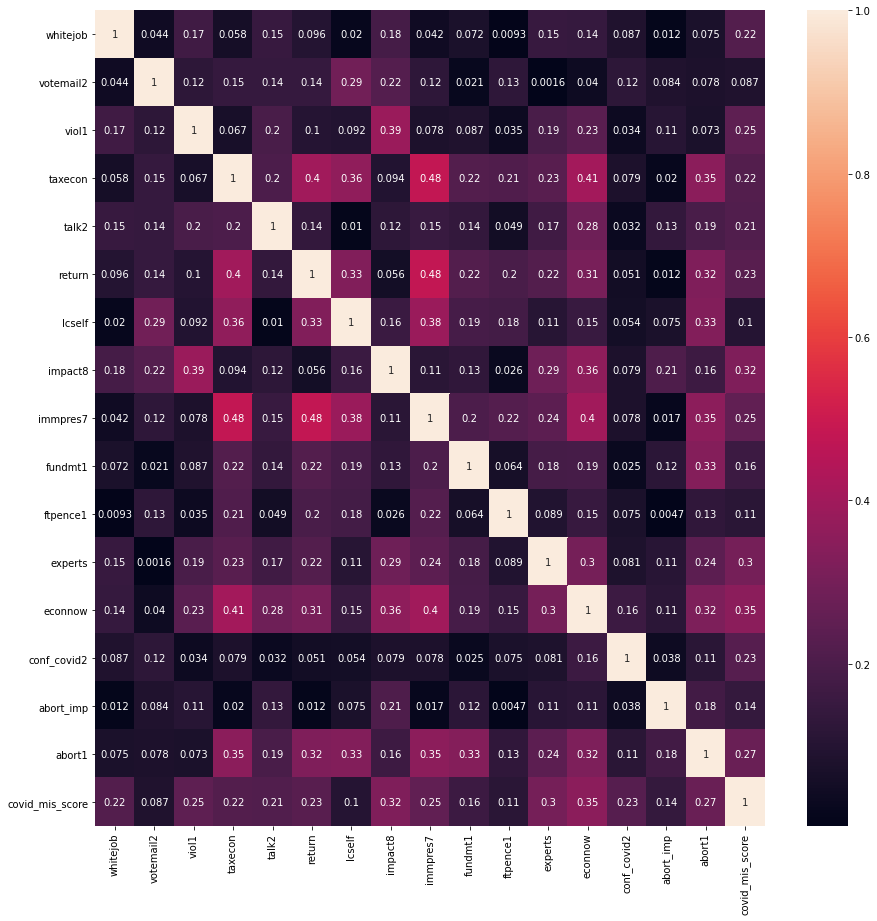

In [69]:
# lets take a look at these important features in a heat map
plt.figure(figsize=(15,15))
sns.heatmap(features16.corr().abs(), annot=True)
plt.show()



In [ ]:



features16 = data[['whitejob', 'votemail2', 'viol1', 'taxecon', 'talk2', 'return', 'lcself', 'impact8', 'immpres7', 'fundmt1', 'ftpence1', 'experts', 'econnow', 'conf_covid2', 'abort_imp', 'abort1', 'covid_mis_score']]

In [57]:
data['whitejob'].value_counts()
#scale of 1-5
#drop 6 and 9
#1 = not at all likely 
# 7 = extremely likely 

2    764
1    730
6    558
3    549
4    255
5    214
9      2
Name: whitejob, dtype: int64

In [70]:
data['votemail2'].value_counts()
#scale of 1-5
# 1 = great deal 
# 5 = not at all 
# trust about mail in ballots being counted accurately

3    906
2    676
1    660
4    443
5    382
9      5
Name: votemail2, dtype: int64

In [71]:
data['viol1'].value_counts()
#scale of 1-5
# 1= great deall 
# 5 = not at all 

5    1323
3     596
4     449
2     358
1     343
9       3
Name: viol1, dtype: int64

In [72]:
data['taxecon'].value_counts()
#scale of 1-7 
#drop 9

4    837
3    562
1    490
2    415
7    282
5    245
6    240
9      1
Name: taxecon, dtype: int64

In [73]:
data['talk2'].value_counts()
#scale of 1-7

4    1354
1     441
2     364
3     261
5     246
7     220
6     186
Name: talk2, dtype: int64

In [74]:
data['return'].value_counts()
#scale 1-5 
#drop 9

1    938
3    646
2    589
4    466
5    432
9      1
Name: return, dtype: int64

In [75]:
data['lcself'].value_counts()
#scale 1-7

4    792
1    453
2    428
7    420
6    345
5    331
3    303
Name: lcself, dtype: int64

In [76]:
data['race7'].value_counts()

1    2156
5     367
2     326
3     112
4      87
6      16
7       6
9       2
Name: race7, dtype: int64